# British Columbia Hydraulic Fracturing Water Use Analysis  
**Case Study**

## Overview
This notebook analyzes **hydraulic fracturing water use in British Columbia** using publicly available **FracFocus data** published by the British Columbia Energy Regulator (BCER).

The goal of this analysis is to:
- Examine **water volumes used during hydraulic fracturing**
- Identify **trends over time**
- Summarize **water use patterns by region or well area**
- Demonstrate a clear, reproducible **data cleaning and analysis workflow**

This work is part of a take-home case study focused on data handling, interpretation, and communication rather than advanced modeling.

---

## Data Source
- **BIL-183 – Complete FracFocus Data (BC)**
- Publisher: :contentReference[oaicite:0]{index=0}
- Data format: CSV (public regulatory dataset)

The FracFocus dataset reports hydraulic fracturing information at the **ingredient level**, meaning each fracture event may appear across multiple rows.

---

## Important Assumptions
- **Total Water Volume (m³)** represents the reported water injected per fracture event.
- To avoid double-counting, fracture events will be **aggregated by well and fracture date**.
- The analysis reflects **reported fracturing activity only** and does not represent full lifecycle water use, reuse, or disposal.

---

## Scope and Limitations
This analysis focuses on:
- Fracturing water volumes
- Temporal trends
- Regional or area-level summaries

It does **not** evaluate:
- Chemical composition of fracture fluids
- Water disposal or recycling efficiency
- Environmental impact beyond reported volumes

---

## Tools Used
- Python
- pandas, numpy
- matplotlib
- Jupyter Notebook

---

## Notebook Structure
1. Data loading and initial inspection  
2. Data cleaning and aggregation  
3. Summary statistics and trends  
4. Visualizations  
5. Key observations and limitations


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

print("Notebook ready")


Notebook ready


Load the raw CSV

In [2]:
from pathlib import Path
import pandas as pd

DATA_PATH = Path("../data/raw")
csv_file = DATA_PATH / "Fracture Fluid Data.csv"

df = pd.read_csv(
    csv_file,
    encoding="latin1",   # handles Windows-encoded characters
    low_memory=False
)

df.head()


Fracture Date  WA Number Well Area Name Operator  \
0   05-DEC-2025      51894           INGA   ARCRES   
1   05-DEC-2025      51894           INGA   ARCRES   
2   05-DEC-2025      51894           INGA   ARCRES   
3   05-DEC-2025      51894           INGA   ARCRES   
4   05-DEC-2025      51894           INGA   ARCRES   

                       Well Name     Latitude     Longitude               UWI  \
0  ARCRES  HZ INGA D11-25-084-24  56 18 46.72  121 39 08.07  100123508424W600   
1  ARCRES  HZ INGA D11-25-084-24  56 18 46.72  121 39 08.07  100123508424W600   
2  ARCRES  HZ INGA D11-25-084-24  56 18 46.72  121 39 08.07  100123508424W600   
3  ARCRES  HZ INGA D11-25-084-24  56 18 46.72  121 39 08.07  100123508424W600   
4  ARCRES  HZ INGA D11-25-084-24  56 18 46.72  121 39 08.07  100123508424W600   

                   Trade Name              Supplier           Purpose  \
0  SFR-400 (Friction Reducer)  STEP Energy Services  Friction Reducer   
1  SFR-400 (Friction Reducer)  STEP Energy Services  Friction Reducer   
2                      SIC-3N  STEP Energy Services     Iron Chelator   
3                      SIC-3N  STEP Energy Services     Iron Chelator   
4                     SIC-3NL  STEP Energy Services     Iron Chelator   

  CAS Number Ingredient Comments Ingredient Name  \
0  9003-05-8                 NaN  Polyacrylamide   
1  9003-05-8                 NaN  Polyacrylamide   
2          -                 NaN     Undisclosed   
3          -                 NaN     Undisclosed   
4          -                 NaN     Undisclosed   

   Ingredient Concentration in HF Fluid % by Mass  \
0                                          0.0569   
1                                          0.0569   
2                                          0.0003   
3                                          0.0003   
4                                          0.0093   

   Ingredient Percentage in Additive by % Mass  Total Water Volume (m^3)  
0                                        100.0                  53074.54  
1                                        100.0                  53074.54  
2                                        100.0                  53074.54  
3                                        100.0                  53074.54  
4                                        100.0                  53074.54

## What the Cleaning Script Did

### Purpose
The raw **FracFocus (BIL-183)** file is reported at the **ingredient level**, meaning a single hydraulic fracturing event appears across many rows (one per ingredient).  
The script converts this raw table into a **fracture-event dataset** that can be analyzed without double-counting water volumes and can be mapped using coordinates.

---

### Key Steps Performed

1. **Loaded the raw CSV safely**
   - Read the file using `latin1` encoding to avoid Unicode decode errors.

2. **Selected only analysis-relevant fields**
   - Kept columns needed for time trends, regional summaries, and mapping.

3. **Standardized data types**
   - Parsed `Fracture Date` into a real datetime.
   - Converted `Total Water Volume (m^3)` into numeric.
   - Converted coordinates into **decimal degrees** for mapping.

4. **Converted coordinates (important)**
   - The raw coordinates were in **DMS format** (e.g., `56 18 46.72`).
   - The script converted them to **decimal degrees**:
     - `Latitude_dd`
     - `Longitude_dd` (forced negative because BC is west longitude)

5. **Removed invalid rows**
   - Dropped rows missing any of the required analysis fields:
     - `Fracture Date`
     - `UWI`
     - `Total Water Volume (m^3)`
     - valid latitude/longitude after conversion

6. **Aggregated to one row per fracture event**
   - Removed ingredient-level duplicates by keeping **one record per unique**:
     - `UWI` + `Fracture Date`
   - This prevents **double counting** total water volume.

7. **Created a helper field for trend analysis**
   - Added `Year` derived from `Fracture Date`.

8. **Wrote a cleaned output file**
   - Saved the final dataset to:
     - `data/cleaned/fracture_events_cleaned.csv`
   - Output contained **6,500 fracture events**.

---

### Fields Kept (from the raw dataset)
- `Fracture Date`
- `UWI`
- `Well Area Name`
- `Latitude`
- `Longitude`
- `Total Water Volume (m^3)`

### Fields Created (new)
- `Latitude_dd` (decimal degrees)
- `Longitude_dd` (decimal degrees)
- `Year`

---

### Fields Removed (not used for this analysis)
All ingredient / chemical / supplier details were excluded because this case study focuses on **water volume trends and regional summaries**, not fluid chemistry.

Examples of removed fields include:
- `Trade Name`, `Supplier`, `Purpose`
- `CAS Number`, `Ingredient Name`
- `Ingredient Concentration in HF Fluid % by Mass`
- `Ingredient Percentage in Additive by % Mass`
- `Ingredient Comments`
- `Operator`, `Well Name`, `WA Number` *(not required for water-volume trend + mapping outputs)*

---

### Final Output Columns (analysis + mapping ready)
- `Fracture Date`
- `Year`
- `UWI`
- `Well Area Name`
- `Latitude_dd`
- `Longitude_dd`
- `Total Water Volume (m^3)`


## Load Cleaned Fracture Event Dataset

This section loads the cleaned, aggregated fracture-event dataset produced by the data cleaning script.

At this stage:
- Each row represents **one hydraulic fracturing event**
- Ingredient-level duplication has been removed
- Coordinates are available in **decimal degrees** for mapping


In [3]:
import pandas as pd
from pathlib import Path

clean_file = Path("../data/cleaned/fracture_events_cleaned.csv")
events = pd.read_csv(clean_file, parse_dates=["Fracture Date"])

events.head()


Fracture Date  Year               UWI Well Area Name  Latitude_dd  \
0    2025-12-05  2025  100123508424W600           INGA    56.312978   
1    2025-12-05  2025  100133508424W600           INGA    56.313036   
2    2025-12-05  2025  100143508424W600           INGA    56.313094   
3    2025-12-05  2025  100020208524W600           INGA    56.313156   
4    2025-11-25  2025  100113607917W600        SUNRISE    55.894325   

   Longitude_dd  Total Water Volume (m^3)  
0   -121.652242                  53074.54  
1   -121.652119                  51230.95  
2   -121.651997                  52685.17  
3   -121.651878                  52505.73  
4   -120.520197                    407.90

## Data Validation and Quality Checks

Before analysis, basic validation checks are performed to confirm:
- Expected number of fracture events
- No missing critical fields (date, water volume, coordinates)
- Reasonable ranges for water volumes

These checks help ensure results are reliable and interpretable.


In [4]:
events.shape


(6500, 7)

In [5]:
events.isna().sum()


Fracture Date               0
Year                        0
UWI                         0
Well Area Name              0
Latitude_dd                 0
Longitude_dd                0
Total Water Volume (m^3)    0
dtype: int64

In [6]:
events["Total Water Volume (m^3)"].describe()


count      6500.000000
mean      17278.755471
std       13876.867206
min           0.000000
25%        9502.970000
50%       14227.500000
75%       21557.875000
max      170945.200000
Name: Total Water Volume (m^3), dtype: float64

Based on these checks, the dataset is considered complete and suitable for analysis.
Water volume values fall within expected operational ranges for large-scale hydraulic fracturing, and no missing values were identified in critical fields.


## Summary Statistics and Trends

This section summarizes hydraulic fracturing water use in British Columbia using
simple descriptive statistics and time-based aggregation.

The focus is on:
- Overall distribution of water volumes per fracture event
- Changes in total and average water use over time


To understand how fracturing activity changes over time, water use is aggregated
by year and summarized using totals and averages.


In [7]:
by_year = (
    events
    .groupby("Year")["Total Water Volume (m^3)"]
    .agg(
        fracture_events="count",
        total_water_m3="sum",
        avg_water_m3="mean"
    )
    .reset_index()
    .sort_values("Year")
)

by_year


Year  fracture_events  total_water_m3  avg_water_m3
0   2011               10    2.324192e+05  23241.920000
1   2012              435    7.135779e+06  16404.090544
2   2013              454    5.185127e+06  11420.983535
3   2014              666    8.198940e+06  12310.721245
4   2015              538    7.671264e+06  14258.854819
5   2016              329    4.827591e+06  14673.530260
6   2017              562    8.588199e+06  15281.491998
7   2018              498    7.103694e+06  14264.445394
8   2019              402    7.620129e+06  18955.545366
9   2020              332    6.302990e+06  18984.910991
10  2021              455    8.171200e+06  17958.681946
11  2022              409    8.415576e+06  20575.979638
12  2023              456    9.569510e+06  20985.766621
13  2024              597    1.405575e+07  23543.967772
14  2025              357    9.233743e+06  25864.827619

### Interpretation of Annual Summary Statistics

The annual summary indicates that hydraulic fracturing water use in British Columbia
varies substantially over time, driven by both the number of fracture events and
changes in average water volume per event.

From 2011 to the mid-2010s, total water use generally increases as fracturing activity
expands. While the number of fracture events fluctuates year to year, average water
volume per event shows a gradual upward trend, particularly from 2019 onward.

In more recent years (2022–2025), total water use remains high despite variability in
event counts, suggesting that individual fracture operations are, on average, using
larger volumes of water. This pattern is consistent with longer horizontal wells and
more intensive multi-stage fracturing practices.


In [8]:
by_year.style.format({
    "total_water_m3": "{:,.0f}",
    "avg_water_m3": "{:,.0f}"
})


## Regional Summary of Water Use

To understand how hydraulic fracturing water use is distributed spatially,
fracture events are summarized by **Well Area Name**.

This highlights which regions account for the largest share of total water use
and whether differences are driven by event counts or average water volume per event.


In [9]:
by_area = (
    events
    .groupby("Well Area Name")["Total Water Volume (m^3)"]
    .agg(
        fracture_events="count",
        total_water_m3="sum",
        avg_water_m3="mean"
    )
    .reset_index()
    .sort_values("total_water_m3", ascending=False)
)

by_area.head(10)


Well Area Name  fracture_events  total_water_m3   avg_water_m3
128        SUNRISE              762    1.192363e+07   15647.809767
141           TOWN              663    1.141177e+07   17212.329585
8          ALTARES              431    9.591647e+06   22254.400745
22       BLUEBERRY              119    4.722734e+06   39686.838588
75            INGA              170    4.713783e+06   27728.137741
54             DOE              339    4.046470e+06   11936.489344
122       SEPTIMUS              262    3.867980e+06   14763.282941
67     GROUNDBIRCH              261    3.460049e+06   13256.892567
80        KIWIGANA               32    3.311117e+06  103472.398125
127        SUNDOWN              225    3.097528e+06   13766.791404

### Interpretation of Regional Water Use Patterns

Hydraulic fracturing water use in British Columbia is highly concentrated within a
small number of well areas. Regions such as **SUNRISE** and **TOWN** account for the
largest share of total water use, driven primarily by a high number of fracture events.

Other areas, including **ALTARES**, **BLUEBERRY**, and **INGA**, show fewer fracture
events but comparatively higher average water volumes per event. This suggests that
regional differences are influenced not only by activity levels, but also by
variations in well design, lateral length, and fracturing intensity.

Overall, the regional distribution indicates that provincial water use impacts are
not evenly distributed, with a limited number of areas contributing a disproportionate
share of total fracturing-related water demand.


## Visualizations

This section adds a small set of visualizations to support the summary statistics and trends.
Charts are intentionally simple and directly tied to the questions:
- How does water use change over time?
- Which regions account for the largest share?
- How does activity level relate to water-use intensity?
- What does the distribution of water volume per event look like?


### Total Water Use Over Time (Annual)

This chart shows total reported hydraulic fracturing water volume by year.


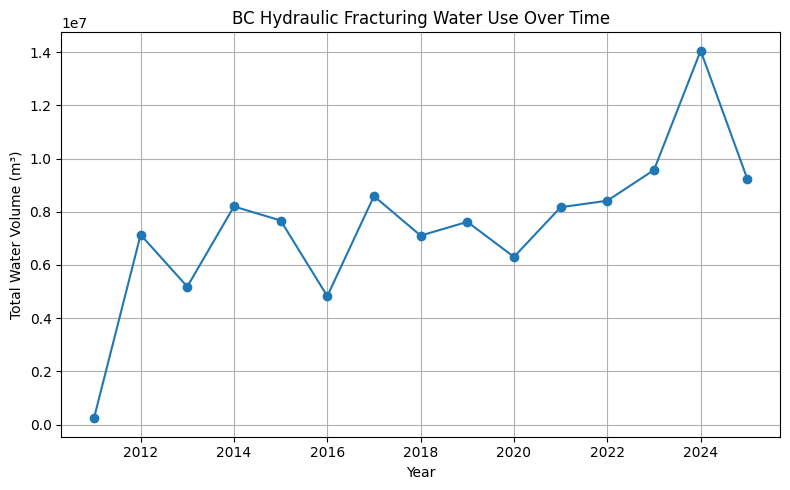

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(by_year["Year"], by_year["total_water_m3"], marker="o")
plt.xlabel("Year")
plt.ylabel("Total Water Volume (m³)")
plt.title("BC Hydraulic Fracturing Water Use Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation of Annual Water Use Trend

This visualization shows total reported hydraulic fracturing water use in British
Columbia by year. While annual totals fluctuate, the overall pattern indicates
increasing water use over time, with notably higher volumes in recent years.

The upward trend in later years suggests that, despite variability in the number
of fracture events, individual operations are using larger volumes of water on
average. This is consistent with the continued development of longer horizontal
wells and more intensive multi-stage fracturing practices.


### Top Well Areas by Total Water Use

This chart highlights the well areas that contribute the largest share of total water use.


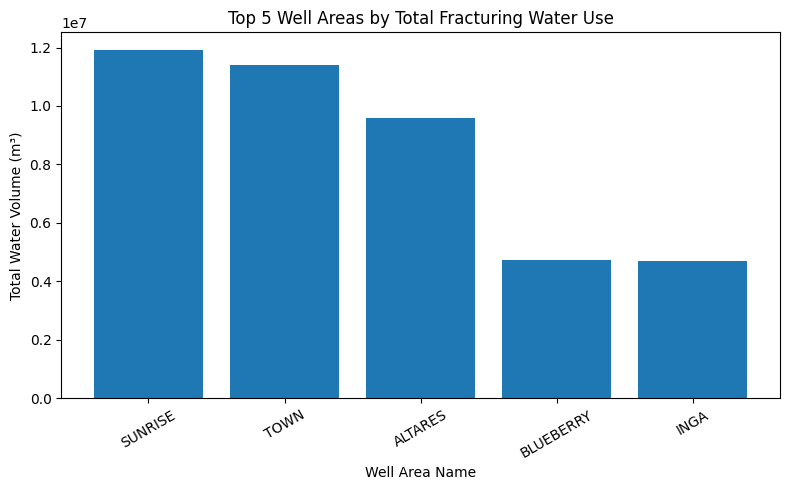

In [11]:
top_regions = by_area.head(5)

plt.figure(figsize=(8, 5))
plt.bar(top_regions["Well Area Name"], top_regions["total_water_m3"])
plt.xlabel("Well Area Name")
plt.ylabel("Total Water Volume (m³)")
plt.title("Top 5 Well Areas by Total Fracturing Water Use")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


### Interpretation of Top Well Areas by Water Use

This chart shows that hydraulic fracturing water use in British Columbia is concentrated
within a small number of well areas. **SUNRISE** and **TOWN** account for the largest
share of total water use, reflecting both high levels of fracturing activity and sustained
development in these regions.

Other areas such as **ALTARES**, **BLUEBERRY**, and **INGA** contribute smaller but still
significant portions of total water use, indicating that water demand is not evenly
distributed across the province. Overall, the results highlight a regional concentration
of water-intensive operations rather than uniform usage across all well areas.


### Activity vs Intensity by Region

This scatter plot compares the number of fracture events in each well area to the average
water volume per event. It helps distinguish areas dominated by many events versus fewer,
more water-intensive events.


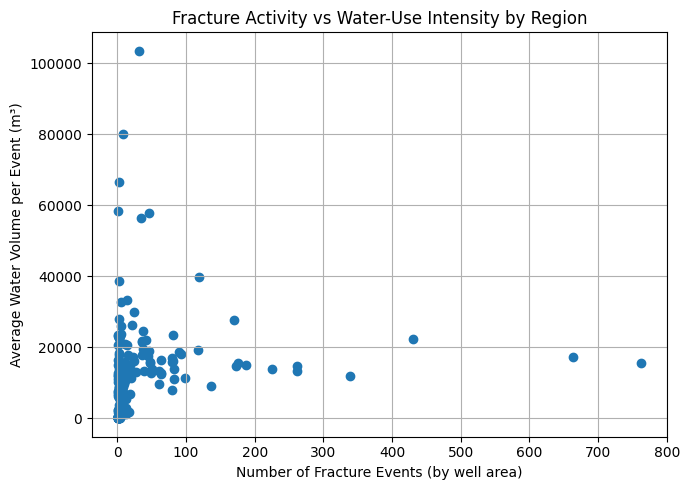

In [12]:
plt.figure(figsize=(7, 5))
plt.scatter(by_area["fracture_events"], by_area["avg_water_m3"])
plt.xlabel("Number of Fracture Events (by well area)")
plt.ylabel("Average Water Volume per Event (m³)")
plt.title("Fracture Activity vs Water-Use Intensity by Region")
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation of Activity vs. Water-Use Intensity

This scatter plot shows the relationship between the number of fracture events in each
well area and the average water volume used per event.

Regions with a high number of fracture events generally exhibit moderate average water
volumes per event, while regions with fewer events display a much wider range of average
water use. This indicates that total regional water use can be driven either by high
activity levels or by fewer, more water-intensive fracture operations.

Overall, the plot highlights substantial variability in fracturing practices across
regions, suggesting that regional water demand is influenced by both development scale
and operational intensity rather than event count alone.


### Distribution of Water Volume per Fracture Event

This histogram shows how water volume is distributed across fracture events and whether
the data contains a long tail of high-volume events.


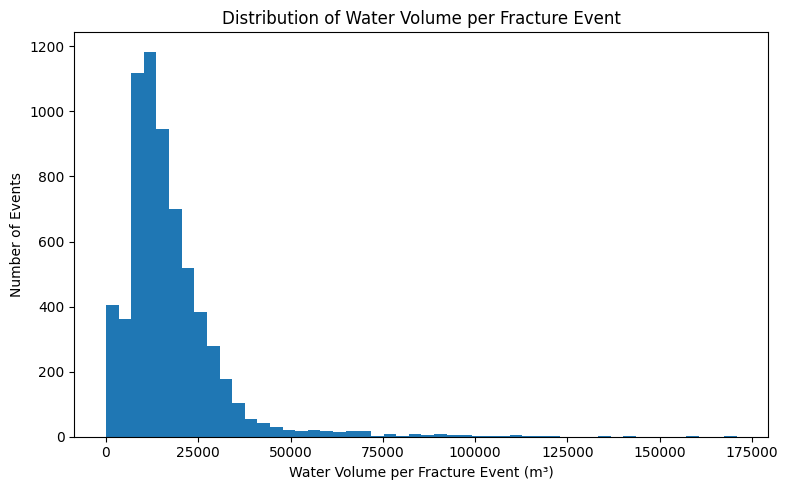

In [13]:
plt.figure(figsize=(8, 5))
plt.hist(events["Total Water Volume (m^3)"], bins=50)
plt.xlabel("Water Volume per Fracture Event (m³)")
plt.ylabel("Number of Events")
plt.title("Distribution of Water Volume per Fracture Event")
plt.tight_layout()
plt.show()


### Interpretation of Water Volume Distribution

The distribution of water volume per fracture event is strongly right-skewed, with the
majority of fracture events using relatively moderate volumes of water and a smaller
number of events using substantially higher volumes.

This long-tailed distribution indicates that while typical fracturing operations cluster
around a common range of water use, a limited number of large or highly intensive
operations contribute disproportionately to overall water demand. These high-volume
events help explain year-to-year variability in total water use.


### Cumulative Water Use Over Time

This chart shows cumulative reported water use over time, which reduces year-to-year noise
and highlights long-term growth in total water demand from fracturing activity.


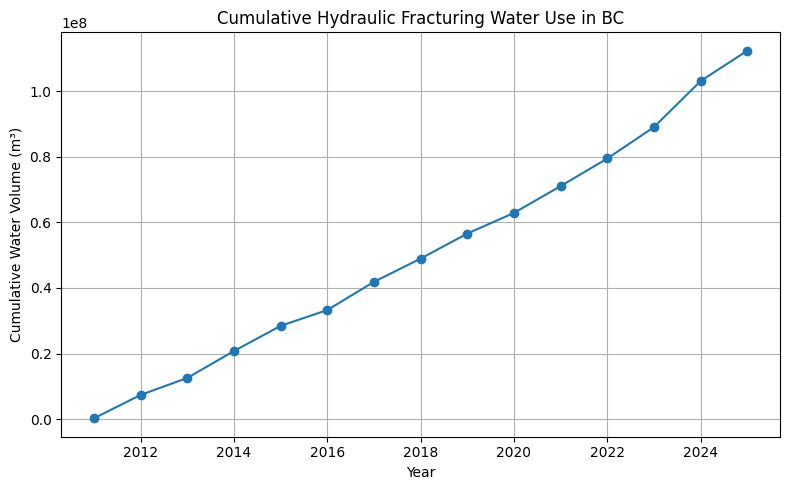

In [14]:
by_year = by_year.copy()
by_year["cumulative_water_m3"] = by_year["total_water_m3"].cumsum()

plt.figure(figsize=(8, 5))
plt.plot(by_year["Year"], by_year["cumulative_water_m3"], marker="o")
plt.xlabel("Year")
plt.ylabel("Cumulative Water Volume (m³)")
plt.title("Cumulative Hydraulic Fracturing Water Use in BC")
plt.grid(True)
plt.tight_layout()
plt.show()


### Interpretation of Cumulative Water Use

The cumulative water use curve shows a steady increase in total reported hydraulic
fracturing water use over time. Unlike annual totals, the cumulative view smooths
short-term variability and highlights long-term growth in overall water demand.

The consistently upward trajectory indicates that water use from fracturing activity
has accumulated substantially over the study period, with more recent years contributing
a larger share of the total. This reinforces the observation tha


### Mapping Individual Fracture Events

Each point on the map represents a single reported hydraulic fracturing event.
Marker size is scaled by total reported water volume to visually distinguish
lower- and higher-intensity operations.

This view helps identify:
- Spatial clustering of fracture activity
- Areas with consistently higher water use
- The geographic footprint of hydraulic fracturing in northeast British Columbia


In [15]:
import numpy as np
import folium

# Identify the water volume column safely
water_col = None
for c in events.columns:
    if "Total Water Volume" in c:
        water_col = c
        break

water_col


'Total Water Volume (m^3)'

## Mapping Visualizations

Two complementary spatial representations are used:

- A **point-based map with clustering** to display individual fracture events while
  reducing visual clutter in areas of high activity.
- A **heatmap** to highlight areas where water use and fracture activity are spatially
  concentrated.

Together, these visualizations provide both event-level detail and a clear view of
broader regional patterns across northeast British Columbia.

### Point-Based Visualization of Fracture Events (Clustered)

Fracture events are plotted as individual points using their latitude and longitude
coordinates. Clustering is applied to reduce overplotting in dense areas while keeping
event-level detail available through tooltips and popups.


In [25]:
import folium
from folium.plugins import MarkerCluster

# Build a fresh map canvas
bc_center = [56.5, -121.5]
m_cluster = folium.Map(location=bc_center, zoom_start=6, tiles="CartoDB positron")

# Cluster layer for point readability
cluster = MarkerCluster().add_to(m_cluster)

# Sample to keep rendering fast (increase if needed)
point_df = events.sample(min(3000, len(events)), random_state=42).copy()

for _, row in point_df.iterrows():
    water_val = float(row[water_col])

    folium.Marker(
        location=[row["Latitude_dd"], row["Longitude_dd"]],
        tooltip=f"{row['Well Area Name']} | {water_val:,.0f} m³",
        popup=folium.Popup(
            f"""
            <b>UWI:</b> {row['UWI']}<br>
            <b>Well Area:</b> {row['Well Area Name']}<br>
            <b>Year:</b> {row['Year']}<br>
            <b>Total Water:</b> {water_val:,.0f} m³
            """,
            max_width=300
        ),
    ).add_to(cluster)

m_cluster


In [27]:
m_cluster.save("../outputs/fracture_events_clustered.html")


### Heatmap of Water Use Concentration

A heatmap is used to highlight where hydraulic fracturing water use is spatially
concentrated. Water volume is used as a weight so areas associated with higher reported
water use appear more intense on the map.


In [28]:
import folium
from folium.plugins import HeatMap

# Build a fresh map canvas
bc_center = [56.5, -121.5]
m_heat = folium.Map(location=bc_center, zoom_start=6, tiles="CartoDB positron")

# Sample to keep rendering fast (increase if needed)
heat_df = events.sample(min(5000, len(events)), random_state=7).copy()

# Heatmap expects [lat, lon, weight]
heat_data = [
    [r["Latitude_dd"], r["Longitude_dd"], float(r[water_col])]
    for _, r in heat_df.iterrows()
]

HeatMap(
    heat_data,
    radius=18,
    blur=15,
    min_opacity=0.25
).add_to(m_heat)

m_heat


In [29]:
m_heat.save("../outputs/fracture_water_use_heatmap.html")


## Key Findings

- Hydraulic fracturing water use in British Columbia shows substantial variation over
  time, driven by changes in both the number of fracture events and the average water
  volume used per event.

- Average water volume per fracture event has increased in more recent years, suggesting
  a shift toward more water-intensive operations, consistent with longer horizontal wells
  and multi-stage fracturing practices.

- Water use is not evenly distributed across regions. A small number of well areas account
  for a disproportionate share of total reported water use, reflecting concentrated
  development activity.

- Spatial analysis shows clear clustering of fracture events in northeast British Columbia,
  with heatmap results highlighting areas of sustained and intensive water use rather than
  isolated events.

- Distribution analysis indicates a right-skewed pattern, where a relatively small number
  of high-volume fracture events contribute significantly to total water use.


## Challenges and Assumptions

- FracFocus data is reported at the ingredient level, requiring aggregation to derive
  fracture-event-level water volumes. Care was taken to remove duplicate ingredient rows
  to avoid double-counting water use.

- Reported coordinates were provided in degrees–minutes–seconds (DMS) format and required
  conversion to decimal degrees to support spatial analysis and mapping.

- The analysis assumes that reported total water volumes accurately reflect water used
  during hydraulic fracturing operations. No independent verification of reported values
  was performed.

- Spatial visualizations prioritize interpretability. For performance and readability,
  point sampling and visual scaling were applied, while raw values remain available in
  tables and tooltips.

- This analysis focuses on water use during hydraulic fracturing only and does not account
  for water sourcing, disposal, recycling, or broader lifecycle water impacts.
